# MSAI 495: Deep Reinforcement Learning
### Final Project
### Alec Lei, Peter Salvino, Riuze Yang, & Qiaohan Yang

Package requirements:
-datajoint (Requires Python>= 3.4)
-if data is download, please load data with pickle

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt
import ssm
from ssm.util import find_permutation

## Run the following parts if you need to clean the data.
### If not, please download the clean data and skip this part

In [2]:
data_path=r'data/behaviordata'

with open(data_path,'rb') as f:
    data=pk.load(f)
data#[['trial_id','task','maze_id','speed_by_cm']]

,subject_fullname,session_date,session_number,task,protocol_id,trial_id,maze_id,main_maze_id,trial_type,choice,...,t_cue_entry,t_mem_entry,t_turn,t_choice_made,t_reward,t_iti,trial_prior_p_right,reward_amount,block_performance,is_first_trial_of_block
0,apr456_CR1,2021-08-25,1,TowersTaskSwitch,1,1,2,2,R,L,...,2.197650,9.29741,4.098990,11.41410,NaN,12.49730,NaN,0.0,0.000000,1
1,apr456_CR1,2021-08-25,1,TowersTaskSwitch,1,2,1,1,L,L,...,0.643071,2.35999,0.643071,3.94303,3.96019,5.29330,NaN,1.0,0.534483,1
2,apr456_CR1,2021-08-25,1,TowersTaskSwitch,1,3,1,1,R,L,...,0.479739,1.77966,0.496301,2.74630,NaN,3.82951,NaN,0.0,0.534483,0
3,apr456_CR1,2021-08-25,1,TowersTaskSwitch,1,4,1,1,L,L,...,0.433447,1.73349,0.433447,3.59991,3.61670,4.96807,NaN,1.0,0.534483,0
4,apr456_CR1,2021-08-25,1,TowersTaskSwitch,1,5,1,1,L,L,...,0.616672,2.58304,0.749876,3.63356,3.65209,5.09981,NaN,1.0,0.534483,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416783,Unknown_Peter,2022-05-02,1,TowersTaskSwitchEasy,3,1,1,1,R,R,...,3.531830,5.57639,NaN,6.33063,6.37068,7.46811,NaN,1.0,0.800000,1
416784,Unknown_Peter,2022-05-02,1,TowersTaskSwitchEasy,3,2,1,1,R,R,...,0.506757,2.02934,NaN,2.87739,2.91248,4.00242,NaN,1.0,0.800000,0
416785,Unknown_Peter,2022-05-02,1,TowersTaskSwitchEasy,3,3,1,1,L,L,...,0.512285,2.01245,NaN,2.88065,2.91493,3.99704,NaN,1.0,0.800000,0
416786,Unknown_Peter,2022-05-02,1,TowersTaskSwitchEasy,3,4,1,1,L,L,...,0.512026,2.03088,NaN,2.81792,2.85242,3.92763,NaN,1.0,0.800000,0


In [3]:
# remove test mice
data = data[~(data.subject_fullname.isin(["Unknown_Peter", "apr456_CR6error", "lpr6177_test1", "pss3570_TrainTest"]))]

# only keep session with final maze
data = data[data.main_maze_id == 11]

# remove trials in warmup block
data = data[data.maze_id == 11]

# re-index
data.reset_index(drop=True, inplace = True)

data

,subject_fullname,session_date,session_number,task,protocol_id,trial_id,maze_id,main_maze_id,trial_type,choice,...,t_cue_entry,t_mem_entry,t_turn,t_choice_made,t_reward,t_iti,trial_prior_p_right,reward_amount,block_performance,is_first_trial_of_block
0,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,17,11,11,R,R,...,1.20552,3.99751,4.29751,7.14768,7.15610,8.44789,NaN,1.8,1.000000,1
1,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,18,11,11,L,L,...,1.25294,3.86986,3.90327,6.67835,6.68664,7.98687,NaN,1.8,1.000000,0
2,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,19,11,11,L,L,...,1.28354,3.70875,3.70875,7.17565,7.18403,8.46765,NaN,1.8,1.000000,0
3,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,20,11,11,R,R,...,1.23340,3.95028,3.96694,7.61773,7.63231,8.92588,NaN,1.8,1.000000,0
4,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,21,11,11,L,L,...,1.62524,4.23376,4.23376,7.22577,7.23439,8.52593,NaN,1.8,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134369,apr456_TS8,2021-11-09,1,TowersTaskSwitchEasy,3,209,11,11,R,R,...,6.02491,9.70000,9.70833,12.88370,12.89230,14.50070,NaN,3.0,0.333333,0
134370,apr456_TS8,2021-11-09,1,TowersTaskSwitchEasy,3,210,11,11,L,R,...,2.63380,5.45876,6.50895,8.57607,NaN,9.64249,NaN,0.0,0.333333,0
134371,apr456_TS8,2021-11-09,1,TowersTaskSwitchEasy,3,211,11,11,R,R,...,3.08150,5.95687,8.80719,9.73256,9.74058,11.34070,NaN,3.0,0.333333,0
134372,apr456_TS8,2021-11-09,1,TowersTaskSwitchEasy,3,218,11,11,R,R,...,1.11419,3.38098,5.69792,7.87327,7.88175,9.49006,NaN,3.0,1.000000,1


In [4]:
# find sessions with more than 200 trial
session = data.groupby(["subject_fullname", "session_date", "session_number"]).size().reset_index().rename(columns={0:'trial_count'})
session_large = session[session.trial_count > 200]
session_large = session_large.drop('trial_count', 1)

# keep only data in good sessions
data = pd.merge(data, session_large, how='outer', indicator=True)
data = data[data._merge == "both"]

data = data.drop('_merge', 1)
data.reset_index(drop=True, inplace = True)

data

/var/folders/4x/y92l2fhs0vgdynj3nfnsq6k00000gn/T/ipykernel_15058/635239759.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  session_large = session_large.drop('trial_count', 1)
/var/folders/4x/y92l2fhs0vgdynj3nfnsq6k00000gn/T/ipykernel_15058/635239759.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop('_merge', 1)


,subject_fullname,session_date,session_number,task,protocol_id,trial_id,maze_id,main_maze_id,trial_type,choice,...,t_cue_entry,t_mem_entry,t_turn,t_choice_made,t_reward,t_iti,trial_prior_p_right,reward_amount,block_performance,is_first_trial_of_block
0,apr456_CR2,2021-10-12,1,TowersTaskSwitch,2,42,11,11,R,R,...,1.389580,4.16483,4.18150,6.79009,6.79844,8.39887,NaN,2.6,0.857143,1
1,apr456_CR2,2021-10-12,1,TowersTaskSwitch,2,43,11,11,R,R,...,1.485220,3.83549,7.76101,6.33574,6.34406,7.94457,NaN,2.6,0.857143,0
2,apr456_CR2,2021-10-12,1,TowersTaskSwitch,2,44,11,11,L,L,...,1.470130,4.17024,7.32072,6.40382,6.41216,8.00409,NaN,2.6,0.857143,0
3,apr456_CR2,2021-10-12,1,TowersTaskSwitch,2,45,11,11,L,R,...,1.441730,3.83366,3.85037,6.25893,NaN,7.32557,NaN,0.0,0.857143,0
4,apr456_CR2,2021-10-12,1,TowersTaskSwitch,2,46,11,11,R,R,...,1.291490,3.75006,3.75843,9.16722,9.17556,10.76750,NaN,2.6,0.857143,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31119,apr456_TS6,2022-03-03,1,TowersTaskSwitch,6,342,11,11,L,R,...,0.642389,2.23378,NaN,3.64313,NaN,4.71713,NaN,0.0,0.500000,0
31120,apr456_TS6,2022-03-03,1,TowersTaskSwitch,6,343,11,11,L,L,...,0.666824,2.19187,6.53441,4.90092,4.90953,6.55067,NaN,3.0,0.500000,0
31121,apr456_TS6,2022-03-03,1,TowersTaskSwitch,6,344,11,11,R,L,...,14.226500,15.60290,18.05170,17.14340,NaN,18.22670,NaN,0.0,0.500000,0
31122,apr456_TS6,2022-03-03,1,TowersTaskSwitch,6,345,11,11,R,R,...,0.674645,2.03325,NaN,3.80005,3.80832,5.46755,NaN,3.0,0.500000,0


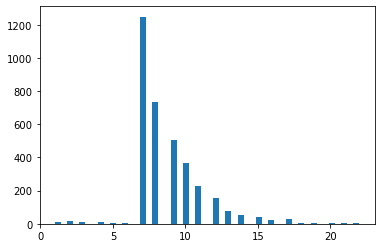

/var/folders/4x/y92l2fhs0vgdynj3nfnsq6k00000gn/T/ipykernel_15058/1869163912.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop('block_keep', 1)


In [5]:
# find the start and length of each block
block_start = data[data.is_first_trial_of_block == 1]
block_start = block_start.index.to_numpy()
block_start = np.append(block_start, len(data))
block_length = np.diff(block_start)

plt.hist(np.sort(block_length)[0:-2], bins = 50)
plt.show()

# keep only blocks with length > 10
block_keep = 1 * (block_length >= 10)
block_keep = np.repeat(block_keep, block_length)
data['block_keep'] = block_keep
data = data[data.block_keep == 1]

data = data.drop('block_keep', 1)
data.reset_index(drop=True, inplace = True)


In [6]:
test = data.groupby(["subject_fullname", "session_date", "session_number"]).size().reset_index().rename(columns={0:'trial_count'})
print(test.to_string())

    subject_fullname session_date  session_number  trial_count
0         apr456_CR2   2021-10-12               1          115
1         apr456_CR3   2021-11-03               1           80
2         apr456_CR3   2021-11-05               1          115
3         apr456_CR3   2021-11-09               1           69
4         apr456_CR3   2021-11-09               2           60
5         apr456_CR3   2021-11-23               1           58
6         apr456_CR3   2022-02-28               1           98
7         apr456_CR3   2022-03-11               1           66
8         apr456_CR3   2022-03-18               2          110
9         apr456_CR4   2021-11-09               1          112
10        apr456_CR4   2021-11-23               1           68
11        apr456_CR4   2022-02-21               1           93
12        apr456_CR4   2022-03-08               1          102
13        apr456_CR4   2022-03-21               1           51
14        apr456_CR5   2022-03-08               1      

In [7]:
# add previous trial response and previous stim
previous_choice=data['choice'].to_numpy()
previous_choice=np.insert(previous_choice,0,'nil')
previous_choice=np.delete(previous_choice,-1)
data['previous_choice']=previous_choice
previous_stim = data['num_towers_delta'].to_numpy()
previous_stim = np.insert(previous_stim, 0, 'nil')
previous_stim = np.delete(previous_stim, -1)
data['previous_stim'] = previous_stim

# remove nil, 1st trial of block
data = data.drop(data[data.choice == 'nil'].index)
data = data.drop(data[data.previous_choice == 'nil'].index)
data = data.drop(data[data.is_first_trial_of_block == 1].index)

In [8]:
data

,subject_fullname,session_date,session_number,task,protocol_id,trial_id,maze_id,main_maze_id,trial_type,choice,...,t_turn,t_choice_made,t_reward,t_iti,trial_prior_p_right,reward_amount,block_performance,is_first_trial_of_block,previous_choice,previous_stim
1,apr456_CR2,2021-10-12,1,TowersTaskSwitch,2,57,11,11,R,R,...,7.35892,5.85887,5.86711,7.45902,NaN,2.6,0.900000,0,L,-3
2,apr456_CR2,2021-10-12,1,TowersTaskSwitch,2,58,11,11,L,L,...,5.65057,6.74227,6.75061,8.34250,NaN,2.6,0.900000,0,R,6
3,apr456_CR2,2021-10-12,1,TowersTaskSwitch,2,59,11,11,R,L,...,4.85061,6.67575,NaN,7.73407,NaN,0.0,0.900000,0,L,-5
4,apr456_CR2,2021-10-12,1,TowersTaskSwitch,2,60,11,11,L,L,...,5.33378,7.18402,7.19241,8.78410,NaN,2.6,0.900000,0,L,4
5,apr456_CR2,2021-10-12,1,TowersTaskSwitch,2,61,11,11,R,R,...,3.53383,6.28397,6.29238,7.89247,NaN,2.6,0.900000,0,L,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11731,apr456_TS6,2022-03-03,1,TowersTaskSwitch,6,315,11,11,R,L,...,NaN,4.15874,NaN,5.24208,NaN,0.0,0.272727,0,R,-5
11732,apr456_TS6,2022-03-03,1,TowersTaskSwitch,6,316,11,11,L,R,...,3.50706,26.29270,NaN,27.36760,NaN,0.0,0.272727,0,L,1
11733,apr456_TS6,2022-03-03,1,TowersTaskSwitch,6,317,11,11,R,R,...,5.25892,3.88370,3.89194,5.53413,NaN,3.0,0.272727,0,R,-1
11734,apr456_TS6,2022-03-03,1,TowersTaskSwitch,6,318,11,11,R,R,...,15.71620,12.74070,12.74900,14.39100,NaN,3.0,0.272727,0,R,8


In [9]:
# save the data
save_path=r'data/behaviordata_clean.csv'
data.to_csv(save_path)

## Load clean data

In [4]:
clean_data_path=r'data/behaviordata_clean.csv'
data=pd.read_csv(clean_data_path)

### Initialize GLM-HMM

In [5]:
# Set the paramters of the GLM-HMM
num_states = 3        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 4         # input dimensions
# bias + previous stim +previous choice +  stim

# Make a GLM-HMM
true_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs",
                   observation_kwargs=dict(C=num_categories), transitions="standard")

In [22]:
true_choice=data['choice'].to_numpy()
true_choice[np.where(true_choice=='L')]=1
true_choice[np.where(true_choice=='R')]=-1
# format for true choice:
# a list of sessions. Each session(i) is an ndarray with data type of int and shape of trial_len(i) x 1
true_choice=[true_choice[:,np.newaxis].astype(int)]

# formate for inpts:
# a list of sessions, same length of true choice.
# #Each session(i) is an ndarray with data type of float and shape of trial_len(i) x input_dim
inpts=data[['previous_choice','previous_stim','num_towers_delta']].to_numpy()
inpts=np.hstack([inpts,np.random.randint(low=-3,high=3,size=(len(inpts),1))])
inpts[np.where(inpts=='L')]=1
inpts[np.where(inpts=='R')]=-1
inpts=[inpts.astype(float)]
print(inpts[0].shape)
print(inpts[0].dtype)
print(true_choice[0].shape)

(10732, 4)
float64
(10732, 1)


### Specify parameters of generative GLM-HMM

Text(0.5, 1.0, 'Generative transition matrix')

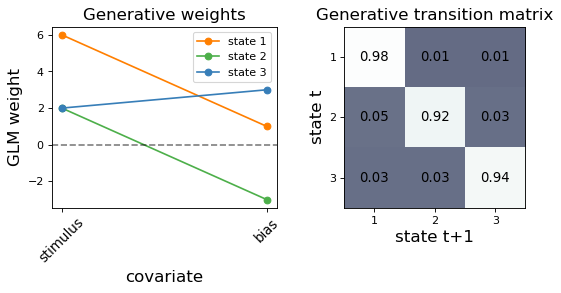

In [5]:
# Plot generative parameters:
fig = plt.figure(figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
cols = ['#ff7f00', '#4daf4a', '#377eb8']
for k in range(num_states):
    plt.plot(range(input_dim), gen_weights[k][0], marker='o',
             color=cols[k], linestyle='-',
             lw=1.5, label="state " + str(k+1))
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Generative weights", fontsize = 15)

plt.subplot(1, 2, 2)
gen_trans_mat = np.exp(gen_log_trans_mat)[0]
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("Generative transition matrix", fontsize = 15)

### External input sequences

Simulate an example set of ecternal inputs fro each trial in a session. We will create an array of size `(num_sess x num_trials_per_sess x num_covariates)`. For each trial in a session we weill include the stimulus presented to the animal at that trial, as well as a  '1' as the second covariate (so as the capture the animals innate bias for one of the two options available to it).

In [25]:
print(true_choice[0].shape)
print(inpts[0].shape)
N_iter=200
fit_ll=true_glmhmm.fit(true_choice,inputs=inpts,method='em',num_iters=N_iter,tolerance=10e-5)

(10732, 1)
(10732, 4)


  0%|          | 0/200 [00:00<?, ?it/s]

In [27]:
# calculate true loglikelihood
true_ll = true_glmhmm.log_probability(true_choice, inputs=inpts)
print("true ll = " + str(true_ll))

true ll = -6396.039284449975


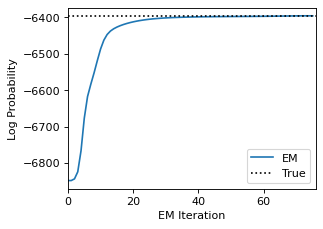

In [28]:
# Plot the log probabilities of the true and fit models. Fit model final LL should be greater
# than or equal to true LL.
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fit_ll, label="EM")
plt.plot([0, len(fit_ll)], true_ll * np.ones(2), ':k', label="True")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, len(fit_ll))
plt.ylabel("Log Probability")
plt.show()

## Retrieved parameters
compare retrieved weights and transition matrices to generatve parameters. First we may need to permute the states of the fit GLM-HMM relative to the generative model. One way to do this uses the `find_permutation` function from `ssm`.

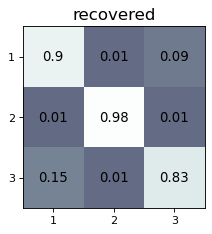

In [29]:
fig = plt.figure(figsize=(5, 2.5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 2)
recovered_trans_mat = np.exp(true_glmhmm.transitions.log_Ps)
plt.imshow(recovered_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(recovered_trans_mat.shape[0]):
    for j in range(recovered_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(recovered_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.title("recovered", fontsize = 15)
plt.subplots_adjust(0, 0, 1, 1)

In [31]:
# Get expected states:
posterior_probs = [true_glmhmm.expected_states(data=data, input=inpt)[0]
                for data, inpt
                in zip(true_choice, inpts)]

Text(0, 0.5, 'p(state)')

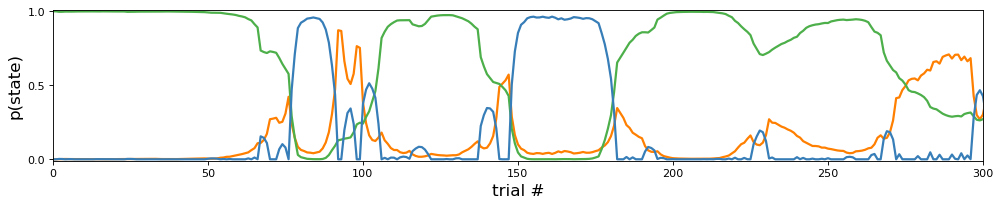

In [35]:
fig = plt.figure(figsize=(15, 2.5), dpi=80, facecolor='w', edgecolor='k')
cols = ['#ff7f00', '#4daf4a', '#377eb8']
sess_id = 0 #session id; can choose any index between 0 and num_sess-1
for k in range(num_states):
    plt.plot(posterior_probs[sess_id][:, k], label="State " + str(k + 1), lw=2,
             color=cols[k])
plt.ylim((-0.01, 1.01))
plt.xlim((0, 300))
plt.yticks([0, 0.5, 1], fontsize = 10)
plt.xlabel("trial #", fontsize = 15)
plt.ylabel("p(state)", fontsize = 15)